In [ ]:
import os
from os.path import join
import numpy as np
import nibabel as nib
from nilearn import datasets
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.colors import ListedColormap 
from neuromaps import transforms
from neuromaps.datasets import fetch_fslr
from gradec.utils import _zero_medial_wall
from surfplot import Plot
%matplotlib inline

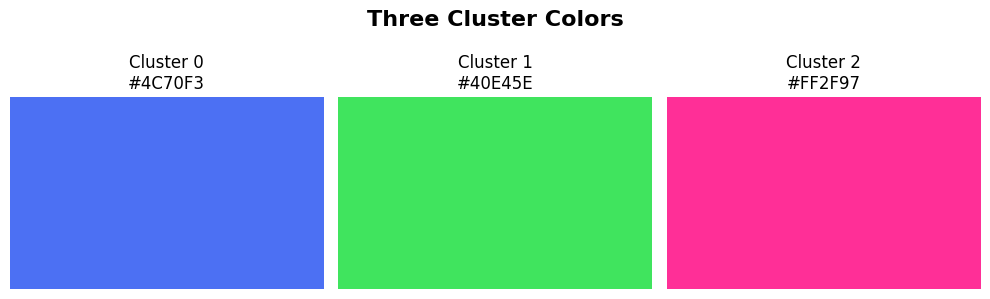

In [ ]:
# Plot three cluster colors as simple swatches
def hex_to_cmap(hex_color, name):
    rgba = to_rgba(hex_color)
    return ListedColormap([rgba], name=name)
cluster_hex = {
    0: "#4C70F3", 
    1: "#40E45E", 
    2: "#FF2F97" 
}
cmaps = [hex_to_cmap(cluster_hex[i], name="f cluster_{i}")
    for i in cluster_hex]

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
fig.suptitle("Three Cluster Colors", fontsize=16, fontweight='bold')

for i, (cluster, color) in enumerate(cluster_hex.items()):
    ax = axes[i]
    gradient = np.ones((10, 100, 3))
    rgb = tuple(int(color.lstrip('#')[j:j+2], 16)/255. for j in (0, 2, 4))
    gradient[:] = rgb
    ax.imshow(gradient, aspect='auto')
    ax.set_title(f"Cluster {cluster}\n{color}", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:

CMAP = "Spectral_r"

def plot_surf(nii_img_thr, mask_contours=None, vmax=8, cmap=CMAP):
    map_lh, map_rh = transforms.mni152_to_fslr(nii_img_thr, fslr_density="32k")
    map_lh, map_rh = _zero_medial_wall(map_lh, map_rh, space="fsLR", density="32k",)
    surfaces = fetch_fslr(density="32k")
    lh, rh = surfaces["inflated"]
    sulc_lh, sulc_rh = surfaces["sulc"]

    p = Plot(surf_lh=lh, surf_rh=rh, layout="grid")
    p.add_layer({"left": sulc_lh, "right": sulc_rh}, cmap="binary_r", cbar=False)
    p.add_layer({"left": map_lh, "right": map_rh}, cmap=cmap, cbar=False, color_range=(-vmax, vmax),)
    if mask_contours:
        mask_lh, mask_rh = transforms.mni152_to_fslr(mask_contours, fslr_density="32k")
        mask_lh, mask_rh = _zero_medial_wall(mask_lh, mask_rh, space="fsLR", density="32k",)
        mask_arr_lh = mask_lh.agg_data()
        mask_arr_rh = mask_rh.agg_data()
        countours_lh = np.zeros_like(mask_arr_lh)
        countours_lh[mask_arr_lh != 0] = 1
        countours_rh = np.zeros_like(mask_arr_rh)
        countours_rh[mask_arr_rh != 0] = 1

        colors = [(0, 0, 0, 0)]
        contour_cmap = ListedColormap(colors, "regions", N=1)
        line_cmap = ListedColormap(["black"], "regions", N=1)
        p.add_layer({"left": countours_lh, "right": countours_rh}, cmap=line_cmap, as_outline=True, cbar=False,)
        p.add_layer({"left": countours_lh, "right": countours_rh}, cmap=contour_cmap, cbar=False,)
    return p.build()

In [ ]:
# Collect the three cluster NIfTI files for plotting

data_dir = "/Users/princess/Desktop/Projects/plotting-brains/data"
cluster_files = [    
    join(data_dir, "k_cluster_maps_k3_group0_tstat_fdr_clust_p-01_vox-50.nii.gz"),
    join(data_dir, "k_cluster_maps_k3_group1_tstat_fdr_clust_p-01_vox-50.nii.gz"),
    join(data_dir, "k_cluster_maps_k3_group2_tstat_fdr_clust_p-01_vox-50.nii.gz")]
cluster_paths = cluster_files
for i, path in enumerate(cluster_paths):
    print(f"Cluster {i} NIfTI: {path}) | Exists: {os.path.exists(path)}")

Cluster 0 NIfTI: /Users/princess/Desktop/Projects/plotting-brains/data/k_cluster_maps_k3_group0_tstat_fdr_clust_p-01_vox-50.nii.gz) | Exists: True
Cluster 1 NIfTI: /Users/princess/Desktop/Projects/plotting-brains/data/k_cluster_maps_k3_group1_tstat_fdr_clust_p-01_vox-50.nii.gz) | Exists: True
Cluster 2 NIfTI: /Users/princess/Desktop/Projects/plotting-brains/data/k_cluster_maps_k3_group2_tstat_fdr_clust_p-01_vox-50.nii.gz) | Exists: True


In [61]:
# fetch once
surf = datasets.fetch_surf_fsaverage()

Creating combined 3-cluster surface visualization...


/Users/princess/Desktop/Projects/plotting-brains/.venv/lib/python3.9/site-packages/nibabel/affines.py:97: RuntimeWarning: divide by zero encountered in matmul
  pts = pts @ rzs.T + trans[None, :]
/Users/princess/Desktop/Projects/plotting-brains/.venv/lib/python3.9/site-packages/nibabel/affines.py:97: RuntimeWarning: overflow encountered in matmul
  pts = pts @ rzs.T + trans[None, :]
/Users/princess/Desktop/Projects/plotting-brains/.venv/lib/python3.9/site-packages/nibabel/affines.py:97: RuntimeWarning: invalid value encountered in matmul
  pts = pts @ rzs.T + trans[None, :]


✓ Saved combined cluster surface plot to ./figures/combined_clusters


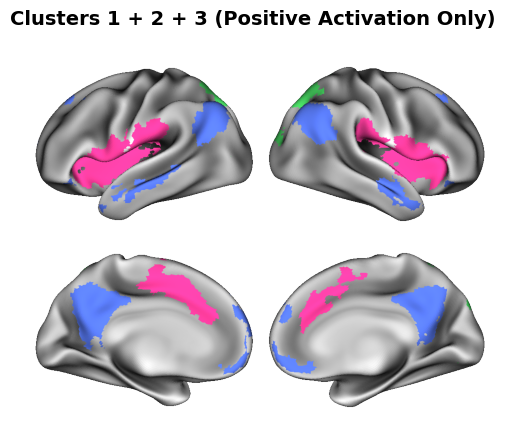

In [ ]:
print("Creating combined 3-cluster surface visualization...")

# --- Surfaces & sulcal depth (fsLR-32k) ---
surfaces = fetch_fslr(density="32k")
lh, rh = surfaces["inflated"]
sulc_lh, sulc_rh = surfaces["sulc"]

# --- Load cluster volumes (assumes 3 paths in cluster_paths) ---
cluster_imgs = [nib.load(p) for p in cluster_paths]

# --- Project clusters to surface & threshold > 0 only ---
cluster_surf_data = []
for img in cluster_imgs:
    # get raw data
    data = img.get_fdata()
    # threshold to positive activation only
    data[data <= 0] = 0
    # rebuild NIfTI with thresholded data
    img_pos = nib.Nifti1Image(data, img.affine, img.header)
    # project to fsLR-32k
    cl_lh, cl_rh = transforms.mni152_to_fslr(img_pos, fslr_density="32k")
    cl_lh, cl_rh = _zero_medial_wall(cl_lh, cl_rh, space="fsLR", density="32k")
    cluster_surf_data.append((cl_lh, cl_rh))
# --- Build plot with sulc base + overlays ---
p = Plot(surf_lh=lh, surf_rh=rh, layout="grid")
# Base layer: sulcal depth
p.add_layer({"left": sulc_lh, "right": sulc_rh}, cmap="binary_r", cbar=False)
# Add overlays for the 3 clusters
cmaps = [hex_to_cmap(cluster_hex[i], name="f_cluster_{i}")
         for i in cluster_hex]
for (cl_lh, cl_rh), cmap in zip(cluster_surf_data, cmaps):
    p.add_layer({"left": cl_lh, "right": cl_rh}, cmap=cmap, cbar=False, color_range=(0, 1))
fig = p.build()
fig.suptitle("Clusters 1 + 2 + 3 (Positive Activation Only)",y=0.95, fontsize=14, fontweight="bold")
surf_file_name = "clusters_1_2_3_posOnly_surface_plot.png"
out_dir = "./figures/combined_clusters"
fig_save_dir = out_dir
fig.savefig(out_dir, dpi=300, bbox_inches="tight",facecolor="white", edgecolor="none")
print(f"✓ Saved combined cluster surface plot to {out_dir}")
plt.show()